## This code was run using the PyTorch 2.4.0 Kernel on Rivanna HPC

We use WandB (weights and biases) to log our model performance and generate the figures in our paper. It is encouraged that those reproducing these results create a wandb account, install wandb, and use `wandb login` to set up logging. However, if you would like to skip this, please remove code involving wandb from the training loop and the notebook should run without problem.

In [1]:
import wandb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.models.video import swin_transformer

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
X = torch.load(dirpath+'X_tensor.pt')
Y = torch.load(dirpath+'Y_tensor.pt')

In [4]:
class TOCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: torch.Tensor of shape (N, 25, 80, 80) - videos
        Y: torch.Tensor of shape (N, 126) - target curves
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]
        curve = self.Y[idx]
        return video, curve

In [5]:
# Define the model
class VideoToCurveModel(nn.Module):
    def __init__(self):
        super(VideoToCurveModel, self).__init__()
        
        # 3D convolution layers to extract spatio-temporal features
        self.conv1 = nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        
        # Fully connected layers for regression
        self.fc1 = nn.Linear(153600, 512)  # Calculate the input size based on the pooling output
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 126)  # Output layer with 126 points

    def forward(self, x):
        # Apply the first convolutional layer
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        # Apply the second convolutional layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        # Flatten the output of the last convolutional layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        #print(x.shape)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        
        return x

In [6]:
# Create dataset and data loader
dataset = TOCDataset(X, Y)
train_size = int(6/7 * len(dataset))
test_size = len(dataset) - train_size
bs = 8

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [7]:
model = VideoToCurveModel()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
# Initialize W&B
wandb.init(
    project="MLIA",
    name="CNN",
    config={
        "learning_rate": 0.001,
        "batch_size": len(train_loader.dataset) // len(train_loader),
        "num_epochs": 250,
        "optimizer": "Adam",
        "loss_function": "MSELoss",
    },
)
config = wandb.config

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Early stopping setup
patience = 5
best_train_loss = float("inf")
patience_counter = 0
best_model_weights = None

# Function to calculate parameter norm
def calculate_param_norm(model, norm_type=2):
    total_norm = 0.0
    for param in model.parameters():
        if param.requires_grad:
            param_norm = param.norm(norm_type)
            total_norm += param_norm.item() ** norm_type
    return total_norm ** (1.0 / norm_type)

# Training loop
num_epochs = config.num_epochs
model.train()
for epoch in range(num_epochs):
    # Initialize variables to track loss and progress
    epoch_loss = 0.0
    
    for inputs, labels in train_loader:
        # Add a channel dimension if not already present
        inputs = inputs.unsqueeze(1)  # Shape becomes [batch_size, 1, 25, 80, 80]
        
        # Move to the device (cuda / CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Compute average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    
    # Compute validation loss
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            valid_loss += criterion(outputs, labels).item()
    avg_valid_loss = valid_loss / len(test_loader)
    model.train()
    
    
    # Calculate parameter norm
    param_norm = calculate_param_norm(model)
    
    # Log metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "valid_loss": avg_valid_loss,
        "param_norm": param_norm,  # Log parameter norm
    })
    
    # Print losses and parameter norm
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Param Norm: {param_norm:.4f}")
    
    # Early stopping logic
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        patience_counter = 0
        best_model_weights = model.state_dict()  # Save the best model weights
        # Save best model to W&B
        wandb.run.summary["best_train_loss"] = best_train_loss
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Validation loss did not improve for {patience} epochs.")
            break

# Restore the best model weights after training
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored the best model weights.")
    wandb.run.summary["early_stopping_epoch"] = epoch + 1

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bae9wk (crg). Use `wandb login --relogin` to force relogin


Epoch 0/250 - Train Loss: 603.3792, Valid Loss: 267.6816, Param Norm: 32.4518
Epoch 5/250 - Train Loss: 204.5539, Valid Loss: 183.6789, Param Norm: 44.3936
Epoch 10/250 - Train Loss: 154.5455, Valid Loss: 157.6618, Param Norm: 52.6616
Epoch 15/250 - Train Loss: 134.6806, Valid Loss: 160.4339, Param Norm: 61.2561
Epoch 20/250 - Train Loss: 72.7025, Valid Loss: 162.7649, Param Norm: 68.1922
Epoch 25/250 - Train Loss: 39.8298, Valid Loss: 132.2989, Param Norm: 74.4832
Epoch 30/250 - Train Loss: 21.3520, Valid Loss: 126.6813, Param Norm: 78.3900
Epoch 35/250 - Train Loss: 19.3952, Valid Loss: 134.7981, Param Norm: 80.0518
Epoch 40/250 - Train Loss: 13.0391, Valid Loss: 121.2788, Param Norm: 81.6808
Epoch 45/250 - Train Loss: 11.9529, Valid Loss: 124.5977, Param Norm: 82.6671
Early stopping triggered. Validation loss did not improve for 5 epochs.
Restored the best model weights.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
param_norm,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▄▃▄▃▃▃▆▅▃▂▂▂▃▂▂▃▂▅▁▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁
best_train_loss,11.17305
early_stopping_epoch,50
epoch,50
param_norm,83.78602
train_loss,12.59776
valid_loss,127.08995


In [9]:
def plot_predictions(predictions, ground_truths, num_samples=16, path='figs/conv_train.png'):
    num_samples = min(num_samples, len(predictions))
    indices = torch.randint(0, len(predictions), (num_samples,))  # Randomly select samples
    
    # Create a grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    for i, idx in enumerate(indices):
        ax = axes[i]  # Get the current subplot axis
        ax.plot(ground_truths[idx].numpy(), label="True Curve", linestyle='--')
        ax.plot(predictions[idx].numpy(), label="Predicted Curve", linestyle='-')
        ax.set_title(f"Sample {i + 1}")
        ax.grid(True)
    
    # Use tight layout
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

# Function to evaluate the model on the test set and compute both MSE and R²
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for videos, curves in test_loader:
            videos = videos.unsqueeze(1)
            videos, curves = videos.to(device), curves.to(device)
            
            # Forward pass
            outputs = model(videos)
            
            # Accumulate predictions and ground truth for plotting
            predictions.append(outputs.cpu())
            ground_truths.append(curves.cpu())
            
            # Compute MSE for the batch
            total_mse += nn.MSELoss()(outputs, curves).item()

    # Concatenate predictions and ground truths for plotting
    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)

    # Compute average MSE
    avg_mse = total_mse / len(test_loader)

    # Compute R² score
    total_r2 = 0
    for i in range(len(predictions)):
        total_r2 += r2_score(predictions[i], ground_truths[i])
    avg_r2 = total_r2 / len(predictions)

    return avg_mse, avg_r2, predictions, ground_truths


In [10]:
!mkdir figs

mkdir: cannot create directory ‘figs’: File exists


Train MSE: 11.6982
Train R²: 0.9225


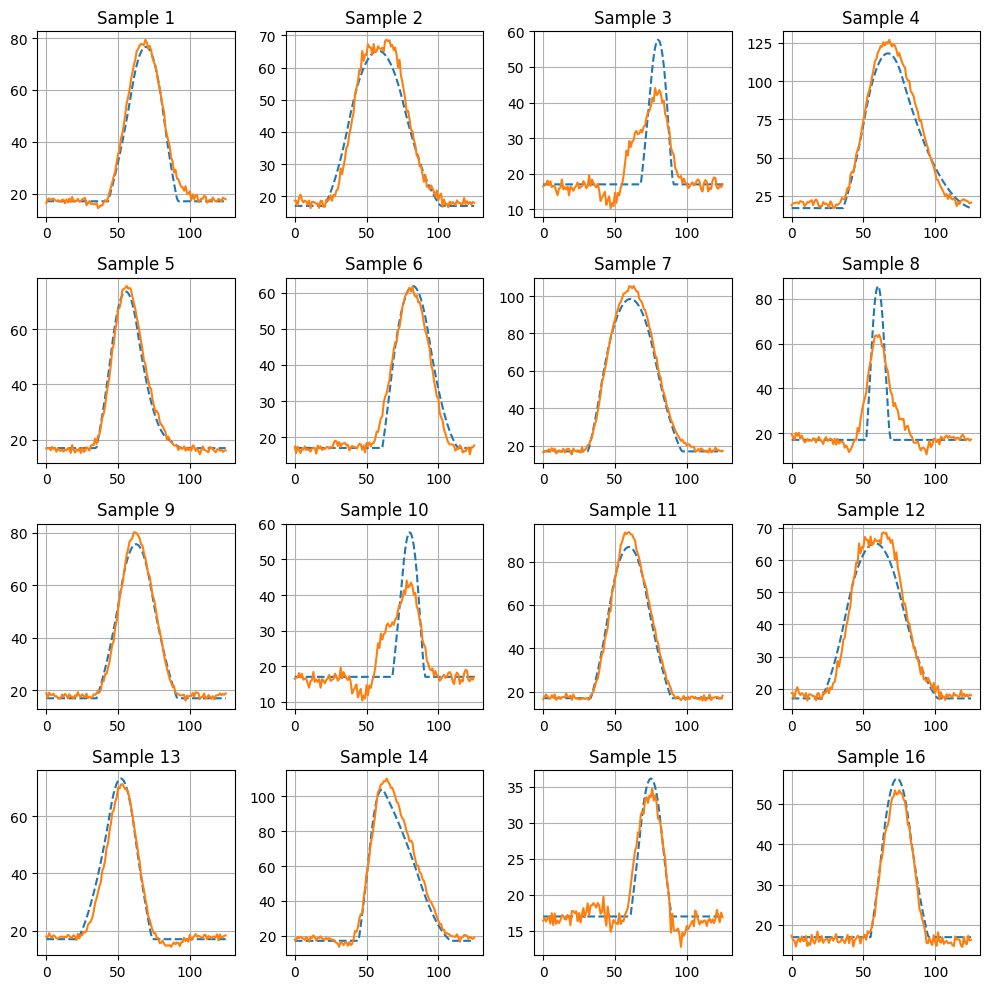

Test MSE: 127.0900
Test R²: 0.5723


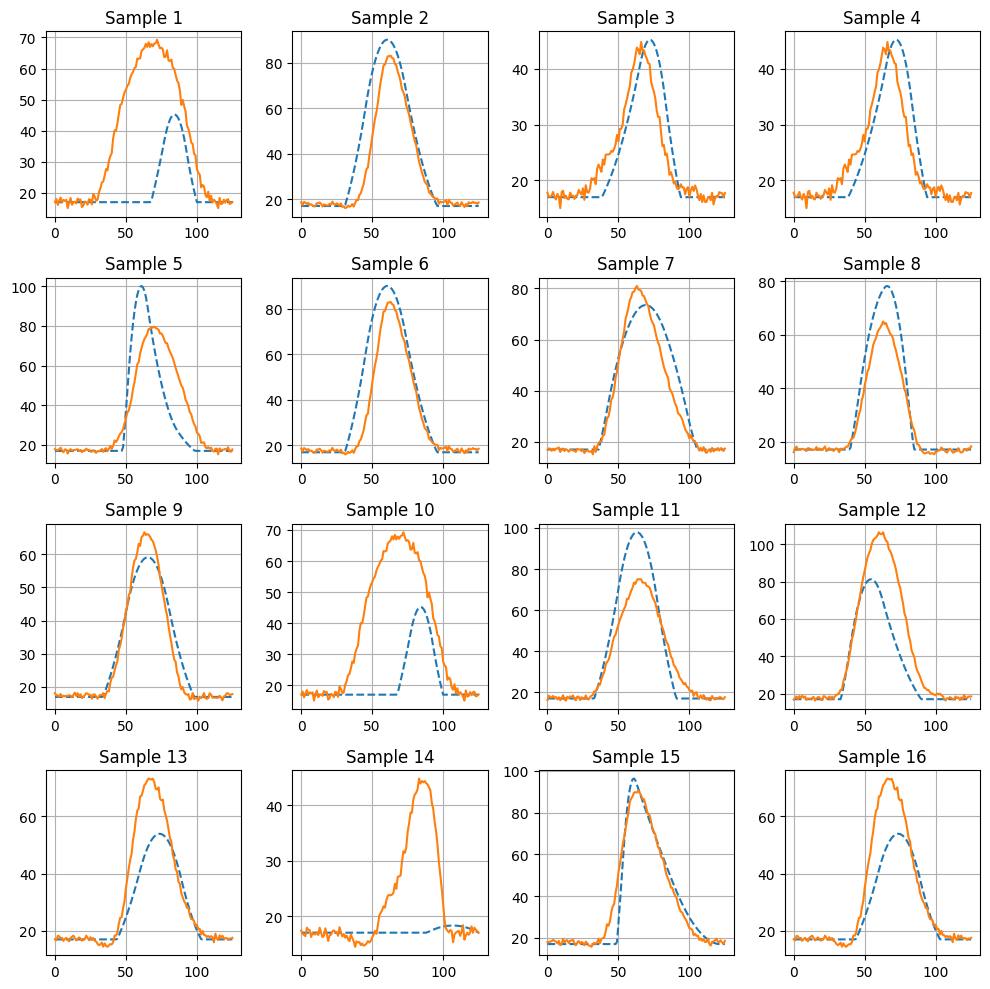

In [11]:
# This cell will only show test output, but will save all results

mse, r2,  predictions, ground_truths = evaluate_model(model, train_loader, device)
print(f"Train MSE: {mse:.4f}")
print(f"Train R²: {r2:.4f}")

plot_predictions(predictions, ground_truths, path='figs/conv_train.png')

mse, r2,  predictions, ground_truths = evaluate_model(model, test_loader, device)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

plot_predictions(predictions, ground_truths, path='figs/conv_test.png')

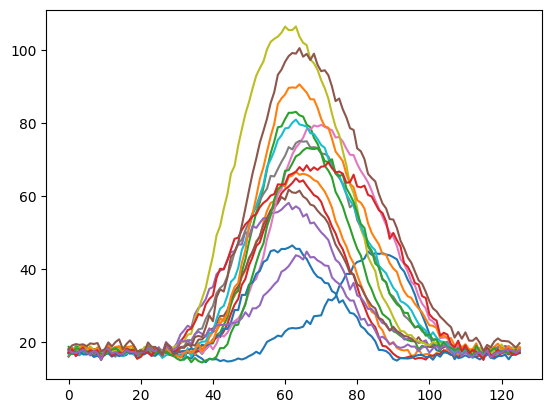

In [12]:
for curve in predictions:
    plt.plot(curve)